In [1]:
setwd('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Eigencytokine Input')
Output = ('/Users/alexis/IEHS Dropbox/Rager Lab/Alexis_Payton/1_Compartment_Analysis/Expt1.5_Baseline Cluster Analyses/Eigencytokine Output')
cur_date = "012121"

library(readxl)
library(dplyr)
library(plyr)
library(tidyverse)
library(janitor)
#library(ltm)
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#library(effects)
library(missForest)
library(tidyr)

#reading in file
cytokines <- data.frame(read_excel("CytokineData_102920.xlsx", sheet = 2))

#reading in demographics file
subjectinfo = data.frame(read_excel("SubjectInfo_102920.xlsx", sheet = 2))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts

First calculating baseline eigencytokines.

In [2]:
#upload cytokine data for each compartment 
ELF_cyto <- read.csv("011921ELF_NonNorm.csv")
NLF_cyto <- read.csv("011921NLF_NonNorm.csv")
Serum_cyto <- read.csv("011921Serum_NonNorm.csv")
Sputum_cyto <- read.csv("011921Sputum_NonNorm.csv")

#transpose cytokine data for each compartment
ELF_cyto <- as.data.frame(t(ELF_cyto)) %>% 
  row_to_names(row_number = 1)
NLF_cyto <- as.data.frame(t(NLF_cyto)) %>% 
  row_to_names(row_number = 1)
Serum_cyto <- as.data.frame(t(Serum_cyto)) %>% 
  row_to_names(row_number = 1)
Sputum_cyto <- as.data.frame(t(Sputum_cyto)) %>% 
  row_to_names(row_number = 1)

#cluster assignments for each compartment 
ELF_clus <- read.csv("011921ELF_cluster_assignments.csv")
NLF_clus <- read.csv("011921NLF_cluster_assignments.csv")
Serum_clus <- read.csv("011921Serum_cluster_assignments.csv")
Sputum_clus <- read.csv("011921Sputum_cluster_assignments.csv")

#reading in scaled data
ELF_cyto_scaled <- read.csv("011921ELF_Scaled.csv")
NLF_cyto_scaled <- read.csv("011921NLF_Scaled.csv")
Serum_cyto_scaled <- read.csv("011921Serum_Scaled.csv")
Sputum_cyto_scaled <- read.csv("011921Sputum_Scaled.csv")

In [3]:
#renaming first column, grouping and splitting by "Cluster" column
ELF_clus <- ELF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
NLF_clus <- NLF_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Serum_clus <- Serum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split
Sputum_clus <- Sputum_clus %>% 
  dplyr::rename(Cytokine = X) %>% 
  group_by(Cluster) %>% 
  group_split

#making dfs for each cluster for PCA analysis 
ELF_1 <- ELF_clus[[1]]
ELF_2 <- ELF_clus[[2]]
ELF_3 <- ELF_clus[[3]]

NLF_1 <- NLF_clus[[1]]
NLF_2 <- NLF_clus[[2]]
NLF_3 <- NLF_clus[[3]]

Serum_1 <- Serum_clus[[1]]
Serum_2 <- Serum_clus[[2]]
Serum_3 <- Serum_clus[[3]]

Sputum_1 <- Sputum_clus[[1]]
Sputum_2 <- Sputum_clus[[2]]
Sputum_3 <- Sputum_clus[[3]]

#making df with subjects' cytokine concentration data for each cluster 
ELF_1 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_2 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
ELF_3 <- ELF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% ELF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

NLF_1 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_2 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
NLF_3 <- NLF_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% NLF_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Serum_1 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_2 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Serum_3 <- Serum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Serum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

Sputum_1 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_1$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_2 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_2$Cytokine) %>% 
  column_to_rownames(var="Cytokine")
Sputum_3 <- Sputum_cyto %>% 
  rownames_to_column("Cytokine") %>% 
  filter(Cytokine %in% Sputum_3$Cytokine) %>% 
  column_to_rownames(var="Cytokine")

In [4]:
#PCA on each cluster, eigenvectors are in rotation -- PROBLEM - for some reason had to convert everything to numeric  
pca_ELF_1 <- ELF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_2 <- ELF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_ELF_3 <- ELF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>%   
  prcomp()

pca_NLF_1 <- NLF_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_2 <- NLF_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_NLF_3 <- NLF_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Serum_1 <- Serum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_2 <- Serum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Serum_3 <- Serum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

pca_Sputum_1 <- Sputum_1 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_2 <- Sputum_2 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()
pca_Sputum_3 <- Sputum_3 %>% 
  lapply(as.numeric) %>% 
  as.data.frame() %>% 
  prcomp()

#eigenvector dfs of first principal component 
eigencytokines_ELF_1 <- data.frame(pca_ELF_1$rotation[,"PC1"])
  colnames(eigencytokines_ELF_1)[1] <- "Cluster1"
eigencytokines_ELF_2 <- data.frame(pca_ELF_2$rotation[,"PC1"])
  colnames(eigencytokines_ELF_2)[1] <- "Cluster2"
eigencytokines_ELF_3 <- data.frame(pca_ELF_3$rotation[,"PC1"])
  colnames(eigencytokines_ELF_3)[1] <- "Cluster3"

eigencytokines_NLF_1 <- data.frame(pca_NLF_1$rotation[,"PC1"])
  colnames(eigencytokines_NLF_1)[1] <- "Cluster1"
eigencytokines_NLF_2 <- data.frame(pca_NLF_2$rotation[,"PC1"])
  colnames(eigencytokines_NLF_2)[1] <- "Cluster2"
eigencytokines_NLF_3 <- data.frame(pca_NLF_3$rotation[,"PC1"])
  colnames(eigencytokines_NLF_3)[1] <- "Cluster3"
  
eigencytokines_Serum_1 <- data.frame(pca_Serum_1$rotation[,"PC1"])
  colnames(eigencytokines_Serum_1)[1] <- "Cluster1"
eigencytokines_Serum_2 <- data.frame(pca_Serum_2$rotation[,"PC1"])
  colnames(eigencytokines_Serum_2)[1] <- "Cluster2"
eigencytokines_Serum_3 <- data.frame(pca_Serum_3$rotation[,"PC1"])
  colnames(eigencytokines_Serum_3)[1] <- "Cluster3"

eigencytokines_Sputum_1 <- data.frame(pca_Sputum_1$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_1)[1] <- "Cluster1"
eigencytokines_Sputum_2 <- data.frame(pca_Sputum_2$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_2)[1] <- "Cluster2"
eigencytokines_Sputum_3 <- data.frame(pca_Sputum_3$rotation[,"PC1"])
  colnames(eigencytokines_Sputum_3)[1] <- "Cluster3"
  

#collapse all eigencytokine dfs
eigencytokines_ELF <- cbind(eigencytokines_ELF_1, eigencytokines_ELF_2, eigencytokines_ELF_3)
eigencytokines_NLF <- cbind(eigencytokines_NLF_1, eigencytokines_NLF_2, eigencytokines_NLF_3)
eigencytokines_Serum <- cbind(eigencytokines_Serum_1, eigencytokines_Serum_2, eigencytokines_Serum_3)
eigencytokines_Sputum <- cbind(eigencytokines_Sputum_1, eigencytokines_Sputum_2, eigencytokines_Sputum_3)

#scale all eigencytokine dfs
eigencytokines_ELF_scaled <- as.data.frame(scale(eigencytokines_ELF))
eigencytokines_NLF_scaled <- as.data.frame(scale(eigencytokines_NLF))
eigencytokines_Serum_scaled <- as.data.frame(scale(eigencytokines_Serum))
eigencytokines_Sputum_scaled <- as.data.frame(scale(eigencytokines_Sputum))

In [ ]:
#export all eigencytokine dfs
write.csv(eigencytokines_ELF, paste0(Output_Folder,"/", "eigencytokines_ELF.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF, paste0(Output_Folder,"/", "eigencytokines_NLF.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum, paste0(Output_Folder,"/", "eigencytokines_Serum.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum, paste0(Output_Folder,"/", "eigencytokines_Sputum.csv"), row.names=TRUE)

write.csv(eigencytokines_ELF_scaled, paste0(Output_Folder,"/", "eigencytokines_ELF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_NLF_scaled, paste0(Output_Folder,"/", "eigencytokines_NLF_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Serum_scaled, paste0(Output_Folder,"/", "eigencytokines_Serum_scaled.csv"), row.names=TRUE)
write.csv(eigencytokines_Sputum_scaled, paste0(Output_Folder,"/", "eigencytokines_Sputum_scaled.csv"), row.names=TRUE)

Now that they eigencytokines have been obtained NLF Cluster 3 needs to be separated out. 

In [5]:
#Cluster 3 in the baseline df and the Cluster 1 in the male df are the same so the name of the baseline cols 
#needs to be changed so they match
names(NLF_cyto_scaled)[1] = 'SubjectID'
eigencytokines_NLF_scaled = eigencytokines_NLF_scaled %>% #converting row names to cols
    rownames_to_column(var = 'SubjectID')
colnames(eigencytokines_NLF_scaled) = c('SubjectID', 'Cluster3', 'Cluster2', 'Cluster1')
NLF_df = full_join(NLF_cyto_scaled,eigencytokines_NLF_scaled)
NLF_df$Analysis = rep('Baseline', times = length(NLF_df$SubjectID)) #adding col to specify baseline or male only eigencytokines
NLF_df$SubjectID = factor(NLF_df$SubjectID, levels = c('NS_1', 'NS_2', 'NS_3', 'NS_4', 'NS_5', 'NS_6', 'NS_7', 'NS_8',
                                                      'NS_9', 'NS_10', 'NS_11', 'NS_12', 'NS_13', 'NS_14'))

Joining, by = "SubjectID"



Now reading in male eigencytokines to make one df. 

In [6]:
NLF_cyto_scaled_male = read.csv('NLF_Scaled_123020.csv')
eigencytokines_NLF_scaled_male = read.csv('eigencytokines_NLF_male.csv')

names(NLF_cyto_scaled_male)[1] = 'SubjectID' #renaming column
names(eigencytokines_NLF_scaled_male)[1] = 'SubjectID'

#need to fix incorrectly labeled Subject IDs
NLF_cyto_scaled_male$SubjectID[NLF_cyto_scaled_male$SubjectID == '43_Ecig'] = 'Ecig_43'
NLF_cyto_scaled_male$SubjectID[NLF_cyto_scaled_male$SubjectID == '44_Ecig'] = 'Ecig_44'
eigencytokines_NLF_scaled_male$SubjectID[eigencytokines_NLF_scaled_male$SubjectID == 'X43_Ecig'] = 'Ecig_43'
eigencytokines_NLF_scaled_male$SubjectID[eigencytokines_NLF_scaled_male$SubjectID == 'X44_Ecig'] = 'Ecig_44'

In [23]:
#removing cigarette smokers
CS = c('CS_23', 'CS_24', 'CS_25', 'CS_26', 'CS_27')
NLF_df_male = full_join(NLF_cyto_scaled_male,eigencytokines_NLF_scaled_male) %>%
    filter(!SubjectID %in% CS)
#reordering subject ids
NLF_df_male$SubjectID = factor(NLF_df_male$SubjectID, levels = c('NS_8', 'NS_9', 'NS_10', 'NS_11', 'NS_12', 'NS_13', 
                                                                 'NS_14', 'Ecig_33', 'Ecig_34', 'Ecig_35', 'Ecig_36', 
                                                                 'Ecig_37','Ecig_38', 'Ecig_39', 'Ecig_40','Ecig_41',
                                                                 'Ecig_42', 'Ecig_43', 'Ecig_44'))
NLF_df_male$Analysis = rep('E-Cigarette & Non-Smoker Males', times = length(NLF_df_male$SubjectID)) #adding col to specify baseline or male only eigencytokines
#creating 1 df
final_df = rbind(NLF_df, NLF_df_male)
head(final_df)

Joining, by = "SubjectID"



,SubjectID,Eotaxin,Eotaxin3,Fractalkine,IFNg,IL10,IL12p70,IL13,IL17B,IL17D,⋯,MCP1,MIG,MIP1a,MIP1b,TARC,TNFa,Cluster3,Cluster2,Cluster1,Analysis
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,NS_1,-0.5630023,-0.4805081,0.6681523,-0.5658910,-0.4260711,-0.8556839,0.6396792,-0.36710910,1.2349944,⋯,0.9936539,1.0919614,-0.7371228,-0.66788368,-0.4377484,0.77256144,0.05976271,-0.5327417,-0.4632075,Baseline
2,NS_10,1.2478897,1.3468201,0.9244682,-0.4538609,-0.4448040,-0.1679861,-0.2004044,0.73336772,0.1071045,⋯,0.8703994,-0.2025715,1.0662956,0.54592172,0.6105605,0.09613807,1.28595874,0.1480348,0.3705725,Baseline
3,NS_11,-0.7282788,-0.1330557,-1.4374693,-0.5760338,-0.7368060,-0.8556839,-0.6728642,0.19905648,-0.9462910,⋯,-1.6267736,-0.9085956,0.5278317,-0.60990041,-1.4041857,-0.87437554,-0.40206720,1.1052660,0.3923003,Baseline
4,NS_12,0.2345743,-0.9425648,0.6237986,0.4574383,0.2951032,-0.8556839,1.7114512,0.36290325,-0.9462910,⋯,-0.4230925,-0.6639902,-0.0413928,0.01950975,0.3642943,1.63936190,-1.75904217,-0.5637463,0.8129353,Baseline
5,NS_13,0.8426756,0.9207279,0.6106723,0.4395231,0.1961496,0.3127131,1.1794078,0.09373333,1.8859341,⋯,0.7520983,1.2282097,-0.1673460,-0.07109781,1.1577067,0.49321311,0.61477421,-1.2849277,0.1599047,Baseline
6,NS_14,0.6561918,-0.2125826,0.3720205,0.2925256,1.0040754,0.7873924,1.2207548,-0.51683698,2.0273798,⋯,0.3661717,1.9264547,0.1590909,0.30538560,-0.3759048,0.77134019,0.27367554,-1.7859351,0.2445334,Baseline


# Visualization of Eigenvector (Figure 4)

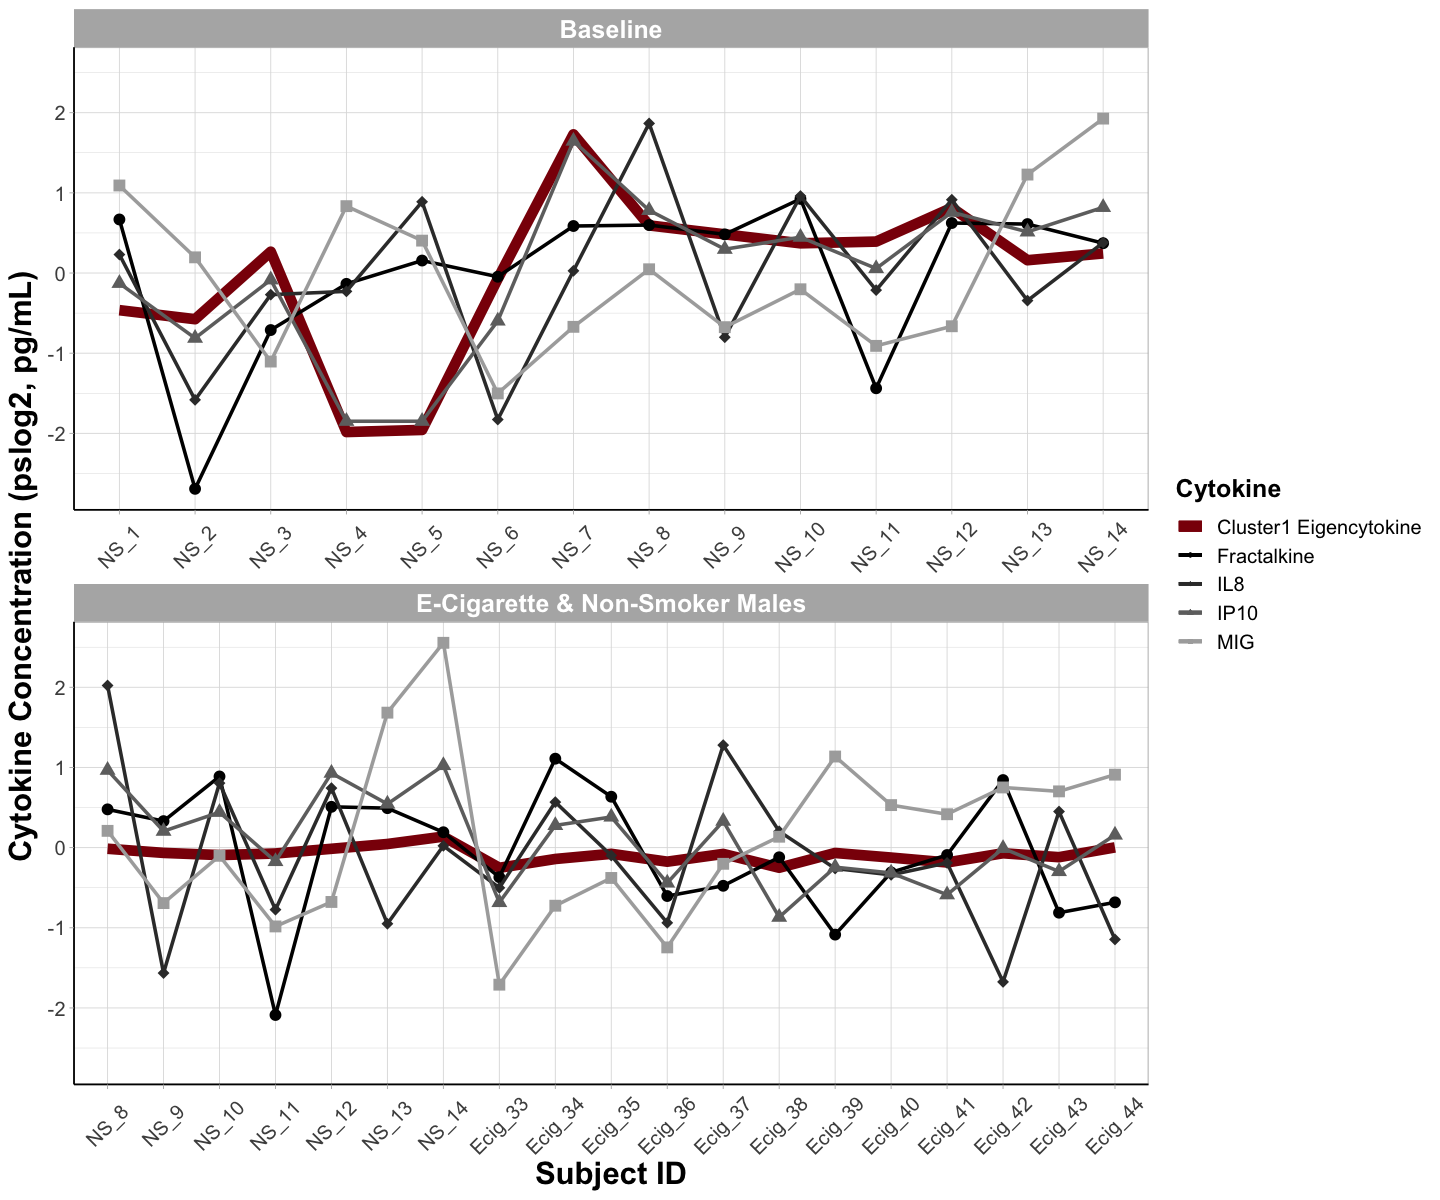

In [24]:
options(repr.plot.width=12, repr.plot.height=10) #changing size
Figure4 = ggplot(data = final_df, aes(SubjectID, y = value, color = variable, group = 1)) + 
  geom_line(aes(y = Cluster1, col = "Cluster1 Eigencytokine"), size = 3) + 
  geom_line(aes(y = Fractalkine, col = "Fractalkine"), size = 1) + 
  geom_point(aes(y = Fractalkine, col = "Fractalkine"), shape = 16, size = 3) +
  geom_line(aes(y = IL8, col = "IL8"), size = 1) + 
  geom_point(aes(y = IL8, col = "IL8"), shape = 18, size = 3) +
  geom_line(aes(y = IP10, col = "IP10"), size = 1) + 
  geom_point(aes(y = IP10, col = "IP10"), shape = 17, size = 3) +
  geom_line(aes(y = MIG, col = "MIG"), size = 1) + 
  geom_point(aes(y = MIG, col = "MIG"), shape = 15, size = 3) +

  facet_wrap(~Analysis, ncol = 1, scales = 'free_x') + 

  theme_light() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Subject ID') + ylab('Cytokine Concentration (pslog2, pg/mL)') + 
  scale_color_manual(values = c('#8b0e09','#000000', '#383838', '#6f6f6f', '#ababab'),
                     guide = guide_legend(title = 'Cytokine', override.aes = list(shape = c(NA,16,18,17,15), 
                                                                                   size = c(3,1,1,1,1))))
Figure4

In [25]:
ggsave(Figure4, 
       filename = 'Figure4.pdf',
       path = Output,
       width = 12, height = 10)

# Test Figure

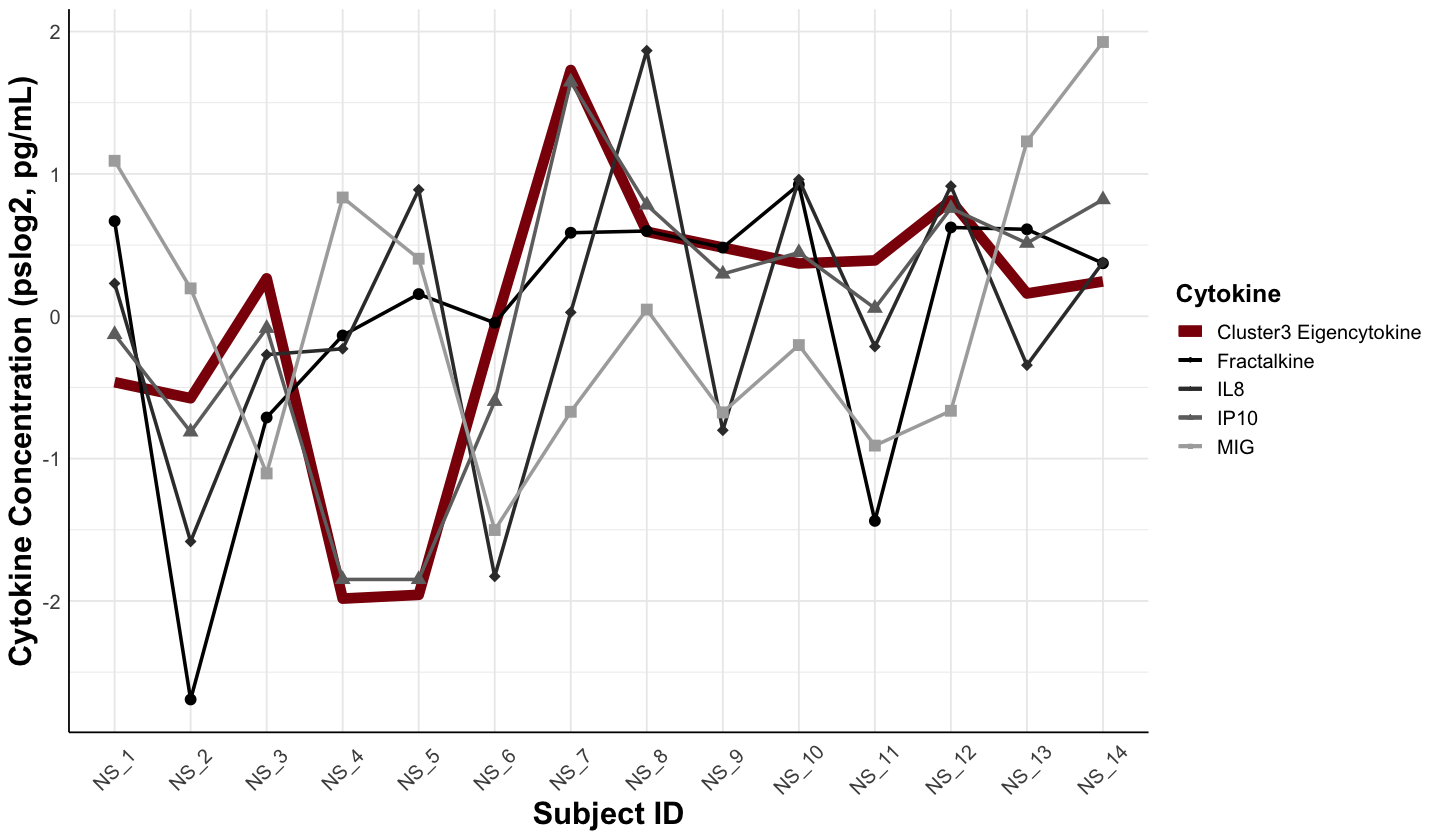

In [7]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot(data = NLF_df, aes(SubjectID, y = value, color = variable, group = 1)) + 
  geom_line(aes(y = Cluster1, col = "Cluster1 Eigencytokine"), size = 3) + 
  geom_line(aes(y = Fractalkine, col = "Fractalkine"), size = 1) + 
  geom_point(aes(y = Fractalkine, col = "Fractalkine"), shape = 16, size = 3) +
  geom_line(aes(y = IL8, col = "IL8"), size = 1) + 
  geom_point(aes(y = IL8, col = "IL8"), shape = 18, size = 3) +
  geom_line(aes(y = IP10, col = "IP10"), size = 1) + 
  geom_point(aes(y = IP10, col = "IP10"), shape = 17, size = 3) +
  geom_line(aes(y = MIG, col = "MIG"), size = 1) + 
  geom_point(aes(y = MIG, col = "MIG"), shape = 15, size = 3) +

  theme_light() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Subject ID') + ylab('Cytokine Concentration (pslog2, pg/mL)') + 
  scale_color_manual(values = c('#8b0e09','#000000', '#383838', '#6f6f6f', '#ababab'),
                     guide = guide_legend(title = 'Cytokine', override.aes = list(shape = c(NA,16,18,17,15), 
                                                                                   size = c(3,1,1,1,1))))